## Index  
* 1. [Import Liabraries](#section_1)    
* 2. [Unzip the files](#section_2)  
* 3. [Human Readable Lable](#label)  
* 4. [Load Pretrained Model](#model)  
* 5. [Predict Crop Image](#Bounding_Box)  
* 6. [NMS](#NMS)


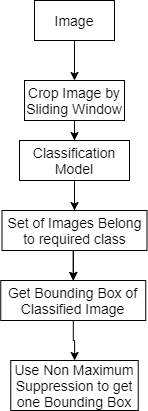

## 1. Import  Liabraries  
<a id = "section_1"></a>


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
# from google.colab.patches import cv2_imshow
from tqdm import tqdm
import os

## 2. Unzip file  
<a id = 'section_2'></a>

In [ ]:
train_zip_path = r'/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
test_zip_path = r'/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'
base_dir = '/kaggle/working/Data/'
unzip_dir = '/kaggle/working/data/'

In [ ]:
if not os.path.exists(unzip_dir):
    os.makedirs(unzip_dir)
    print(f'Directory ceated at {unzip_dir}')
    
import zipfile
with zipfile.ZipFile(train_zip_path) as f:
    f.extractall(unzip_dir)
f.close

## 3. Load human readable Imagenet labels  
<a id ='label'></a>

We will need labels of imagenet , So we will download text file of labels of imagenet.

In [ ]:

labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels = np.array(open(labels_path).read().splitlines())

Now, We know what kind of classes we trying to classify, for example in our case dog, Now, there are several types of dog in imagenet    
labels, So we will store in list so that we can use later in the prediction. (To verify predicted class as dog)  


In [ ]:
dog_classes = []
for idx, i in enumerate(labels):
    if 'dog' in i:
        dog_classes.append(idx)
        print(i)
dog_classes.append(207) # After going though some classes i realized to add golden-retriver present at index 207 
dog_classes.append(245)

In [ ]:
os.listdir('/kaggle/working/data/train/')[1750]

In [ ]:
path =r'/kaggle/working/data/train/dog.11215.jpg'
img = cv2.imread(path)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
print(img.shape) # In the openCv image is of shape (h, w)
org = img.copy()

In [ ]:
window_size = [150,100] 
window_size

## 4. Pretrained Model  
<a id ='model'></a>


In [ ]:
model = tf.keras.applications.ResNet50()

## Code to detect the Object  
<a id ='object'></a>

In [ ]:

bounding_box = []  # We will store coordinate of bounding box (x1, y1, x2, y2)
cropped_images = [] # We will store cropped images, So that we can predict the class of an image

for w in range(8): # I have choosen random value as 8, This means our window will increase 20% each time.
    for y in tqdm(range(0, img.shape[0], 80)): # window will cover 80 pixel in the vertical direction 
        for inc in range(0, img.shape[1], 50): # window will cover 40 pixel in the horizontal direction

            # This condition will prevent window to go outside of image
            if inc +window_size[0]>img.shape[1] or y+window_size[1]>img.shape[0]:  
                break
            
            # This commented line of code will draw sliding window
#             img = cv2.rectangle(img, (inc, y), (inc + window_size[0], y+window_size[1]), (255,125,210), 2)
            
            # We will crop the image of size of sliding window, Make sure we specify dimention (y, x) in opencv slicing
            crop_img = img[ y:y+window_size[1], inc:inc + window_size[0]]
            
            # Seperating B G R channel, as opencv read image as BGR, But to pass image to model we want RGB.
            # So by doing this we will convert BGR to RGB
            
            # This is fficiant way to do slicing or you can use cv.split
            b = crop_img[:,:,0]
            g = crop_img[:,:,1]
            r = crop_img[:,:,2]
            merge = cv2.merge([r,g,b])

            cropped_images.append(merge)
            bounding_box.append([ inc,y, inc + window_size[0], y+window_size[1]])
            
            
            ########################################################################################
            ## This code below was to to predict cropped image one by one, and to show sliding window, 
            ## If uncomment and run it will give you, good visualization how sliding window is working 
            #########################################################################################
            # n_img = tf.keras.applications.resnet50.preprocess_input(merge)
            # prediction = model.predict(tf.expand_dims(tf.image.resize(n_img, (224, 224)), 0))
            # label_no = np.argmax(prediction) 

            # if label_no == 6 and prediction[0][label_no] > 0.80:    # Set prob of class here
            #     bounding_box.append([ inc,y, inc + window_size[0], y+window_size[1]])
                
            # lab = labels[label_no] + '  ' + str(prediction[0][label_no]) 
        
            # cv2.putText(img, lab, (15,15),cv2.FONT_HERSHEY_COMPLEX,  0.7,
            #        (0,0,0),2,4 )
            # cv2.imshow(img)
            # cv2.imshow( crop_img)
            img = org.copy()
            # if cv2.waitKey(1) & 0xFF == ord('q'):
            #     break
            ############################################################################################
            
    window_size = [int(1.2*i) for i in window_size]  # increasing y and x by 20% 
# cv2.waitKey(0)
# cv2.destroyAllWindows()

We are using pretrained resnet 50, So this model requires 224,224 image. But our cropped images are different shapes.
Using tf.image.resize we will resize all images in an array.

## 5. Predict Cropped Images

In [ ]:
def resize_image(x):
    x = tf.convert_to_tensor(x)
    return tf.image.resize(x, (224,224))

def convert_images(cropped_images):
    return [resize_image(i) for i in cropped_images]
li = convert_images(cropped_images)

In [ ]:
# Let's preprocess images using resnet50 preprocessing
all_images_in_array = tf.keras.applications.resnet50.preprocess_input(tf.stack(li))

In [ ]:
predict_prob = model.predict(all_images_in_array) # Get probability distrubution of each images
index_of_required_box = []                        # We will store idex of image which belongs to dog class having probability >=85%
for idx, prob in enumerate(predict_prob):
    id = np.argmax(prob)                     # Get index with highest probability
    if id in dog_classes and prob[id]>0.60:  # Condition to check if probability >= 85%
        index_of_required_box.append(idx)    # Storing indexes of images in list

In [ ]:
np.argmax(predict_prob, axis = 1)

In [ ]:
index_of_required_box

Let's visualize windows predicted by our model for dog

In [ ]:
np.array(bounding_box)[[index_of_required_box]]

In [ ]:
all_bnding_box = org.copy()
for i in np.array(bounding_box)[[index_of_required_box]]:
    cv2.rectangle(all_bnding_box, (i[0],  i[1]), (i[2], i[3]), (255,125,210), 3)

plt.imshow(all_bnding_box)

reference for [Non maximum seperation](https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/) function

## 6. NMS

In [ ]:
def NMS(boxes, overlapThresh):
    #return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We have a least a box of one pixel, therefore the +1
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        temp_indices = indices[indices!=i]
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]
    return boxes[indices].astype(int)

In [ ]:
NMS_box = NMS(np.array(bounding_box)[[index_of_required_box]], overlapThresh = 0.6)
NMS_box = NMS_box.flatten()

In [ ]:
bnding_box_image = org.copy()
for i in bounding_box:
    cv2.rectangle(bnding_box_image, (NMS_box[0],  NMS_box[1]), (NMS_box[2], NMS_box[3]), (255,125,210), 3)

plt.imshow(bnding_box_image)

I will be happy, If you let me know the improvenment and upvote if you like.